# Predicción de la tasa de anillamiento de aves
**Autores:** DANIELLE MAREE MCKENNEY & MARIA JOSÉ CASTRO PÉREZ   &nbsp;&nbsp;&nbsp; **Última modificación:** 14/01/2024

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [2]:
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    df = df[(df['decimalLatitude'] != 0) & (df['decimalLongitude'] != 0)]
    return df

def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'species': data['species'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('species')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

In [3]:
## 1. LECTURA DEL DATASET
DATOS = pd.read_csv('./DATASET.csv', sep="\t", on_bad_lines="warn")
relevantColumns = ['species','locality','decimalLatitude', 'decimalLongitude', 'eventDate', 'stateProvince']

df = cleanRawData(DATOS, relevantColumns)

In [4]:
df

,species,locality,decimalLatitude,decimalLongitude,eventDate,stateProvince
0,Turdus merula,Zona de huertos,41.80000,-2.78333,1980-09-11T00:00:00,Soria
1,Turdus merula,Sant esteve de la sarga,42.06667,0.76667,1983-09-30T00:00:00,Lleida
2,Turdus merula,Sagunto,39.66667,-0.28333,1980-07-12T00:00:00,Valencia
3,Turdus merula,Viernoles,43.31667,-6.06667,1981-03-08T00:00:00,Cantabria
4,Turdus merula,Finca cienfuegos,40.61667,-2.98333,1985-03-31T00:00:00,Guadalajara
...,...,...,...,...,...,...
753574,Phylloscopus collybita,Azuqueca de henares,40.55000,-3.25000,2013-12-27T00:00:00,Guadalajara
753575,Phylloscopus collybita,Reserva del tancat de la pipa,39.35806,-0.36333,2015-01-26T00:00:00,Valencia
753576,Phylloscopus collybita,Tancat de milia,39.31389,-0.36444,2018-12-01T00:00:00,Valencia
753577,Phylloscopus collybita,Navas del rey,40.38333,-4.26667,2019-02-23T00:00:00,Madrid


### 1.2 Agrupaciones por semana, mes, quarter y año

In [5]:

# Group by 'species', 'eventDate', and 'stateProvince' and count the rows in each group
grouped_eventDate_df = df.groupby(['species', 'eventDate', 'stateProvince']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['eventDate', 'stateProvince'])
#print(grouped_eventDate_df[10:])


# Supongamos que 'grouped_eventDate_df' es tu DataFrame y 'eventDate' es la columna que contiene fechas
grouped_eventDate_df['eventDate'] = pd.to_datetime(grouped_eventDate_df['eventDate'])

grouped_eventDate_df['weekOfYear'] = grouped_eventDate_df['eventDate'].dt.isocalendar().week 
grouped_eventDate_df['month'] = grouped_eventDate_df['eventDate'].dt.month
grouped_eventDate_df['quarter'] = grouped_eventDate_df['eventDate'].dt.to_period('Q')
grouped_eventDate_df['year'] = grouped_eventDate_df['eventDate'].dt.year

grouped_weekOfYear_df = grouped_eventDate_df.groupby(['species', 'weekOfYear', 'year', 'stateProvince']).sum('count').reset_index()

grouped_month_df = grouped_eventDate_df.groupby(['species', 'month', 'year', 'stateProvince']).sum('count').reset_index()

grouped_quarter_df = grouped_eventDate_df.groupby(['species', 'quarter', 'stateProvince']).sum('count').reset_index()

grouped_year_df = grouped_eventDate_df.groupby(['species', 'year', 'stateProvince']).sum('count').reset_index()



### 2.1. Conteo de especies por año

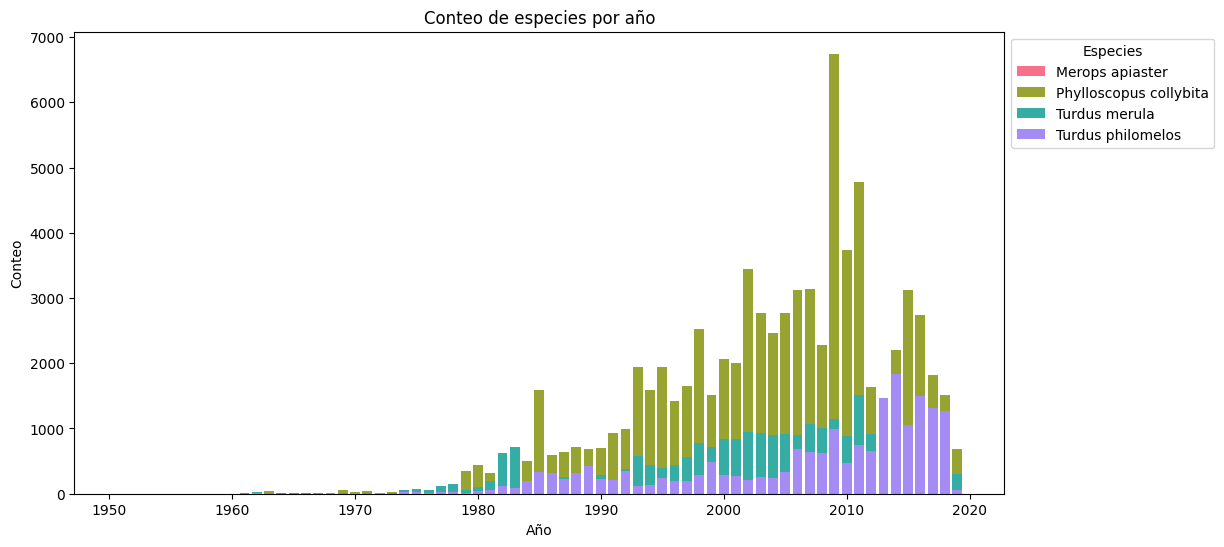

In [6]:
### 2.1. Conteo de especies por año
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una paleta de colores única basada en todas las especies
paleta_colores = sns.color_palette('husl', n_colors=len(grouped_year_df['species'].unique()))
# Mapear cada especie a un color específico
especies_a_colores = dict(zip(grouped_year_df['species'].unique(), paleta_colores))

# Conteo de especies por año
plt.figure(figsize=(12, 6))
for species, data in grouped_year_df.groupby('species'):
    plt.bar(data['year'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de especies por año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.2. Conteo de especies por provincia en los años 2018 al 2019

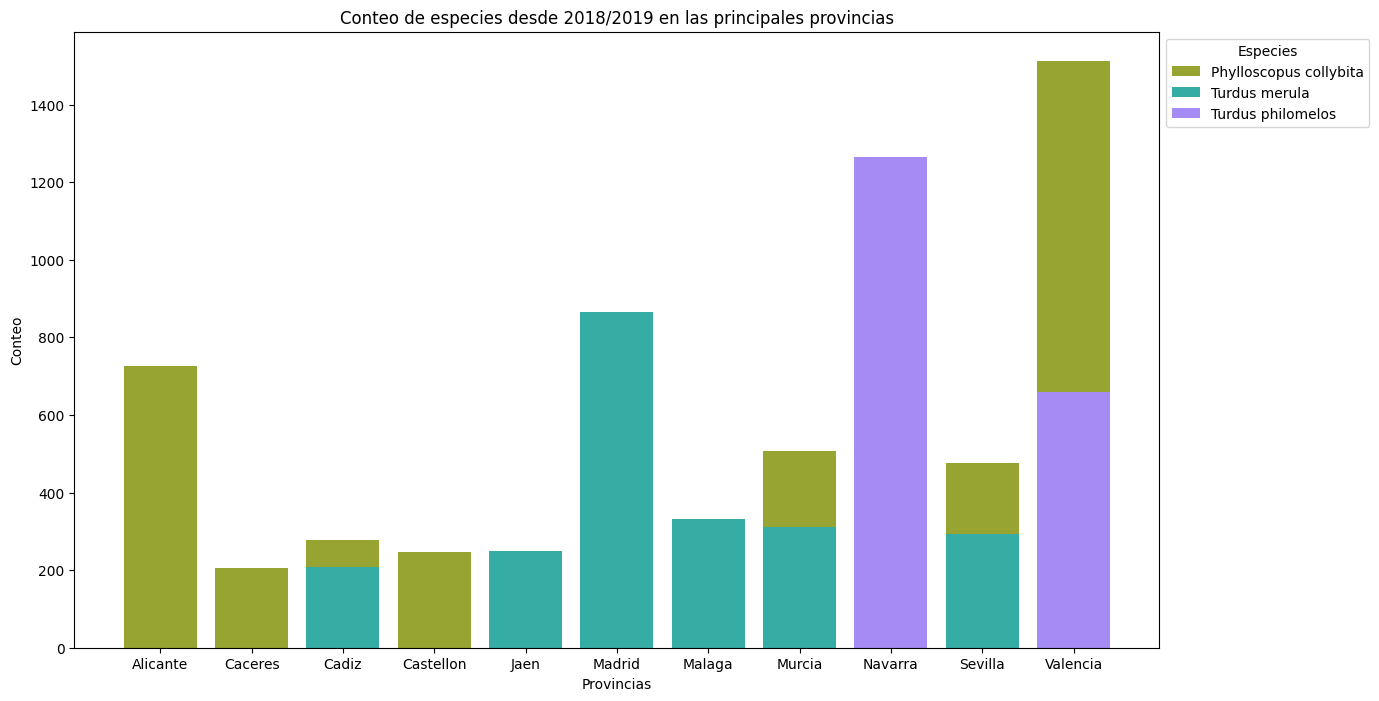

In [7]:
### 2.2. Conteo de especies por provincia en los años 2018 al 2019
plt.figure(figsize=(14, 8))
rango_anos = range(2018, 2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2018/2019 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

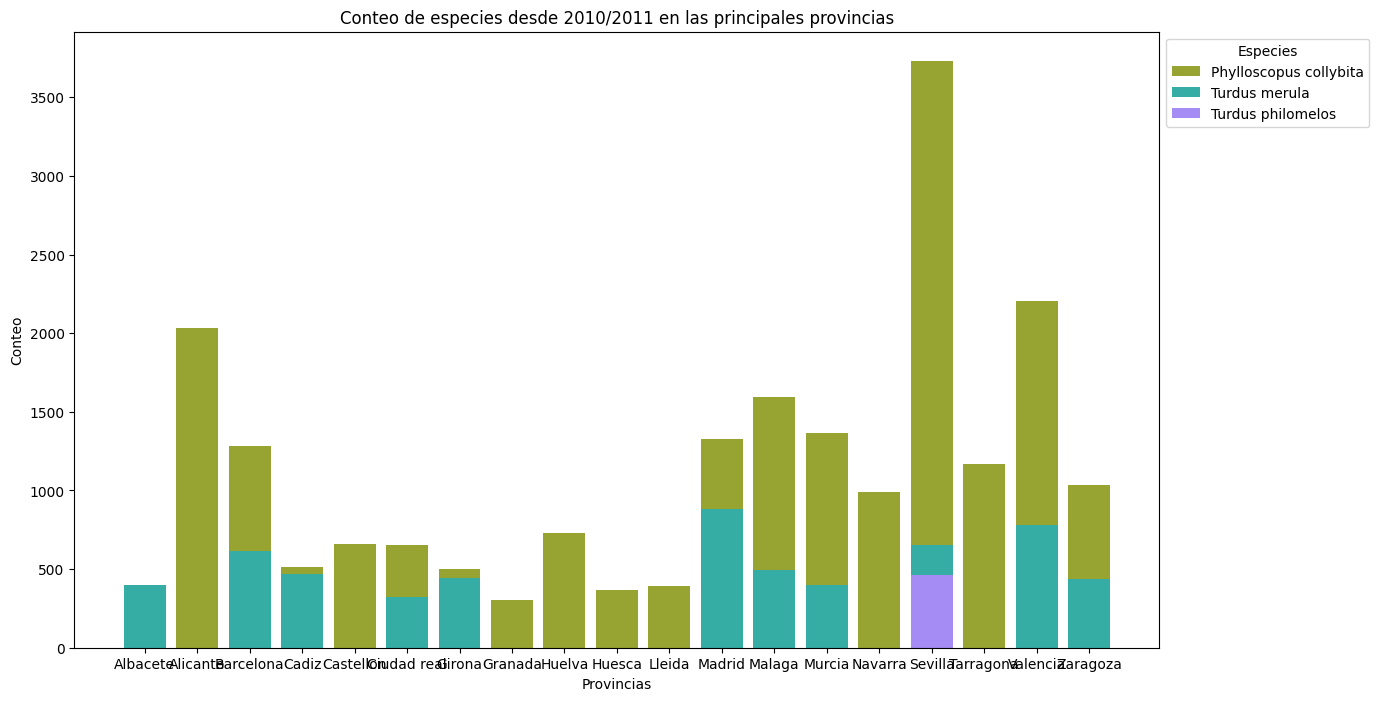

In [8]:
plt.figure(figsize=(14, 8))
rango_anos = range(2010, 2011)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 300)]

for species, data in df_filtrado.groupby('species'):
    plt.bar(data['stateProvince'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Provincias')
plt.ylabel('Conteo')
plt.title('Conteo de especies desde 2010/2011 en las principales provincias')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

### 2.3. Estacionalidad - Conteo de especies por meses

In [9]:
### 2.3. Estacionalidad - Conteo de especies por meses
plt.figure(figsize=(12, 6))
for species, data in grouped_month_df.groupby('species'):
    plt.bar(data['month'], data['count'], label=species, color=especies_a_colores[species])
plt.xlabel('Mes del año')
plt.ylabel('Conteo')
plt.title('Estacionalidad - Conteo de especies por meses del año')
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()



KeyboardInterrupt: 

## 3.Turdus merula : Mirlo

### 3.1. Conteo de Mirlo por año

In [ ]:
## 3.Turdus merula ("Mirlo")
## Estudio de observaciones sobre Turdus merula ("Mirlo")
especie = 'Turdus merula'
nombre_comun = 'Mirlo'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 3.2.Conteo de Mirlo por provincia

In [ ]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 4.Merops apiaster: Abejaruco

### 4.1. Conteo de Abejaruco por año

In [ ]:
#Estudio de Merops apiaste ("Abejaruco ")
especie = 'Merops apiaster'
nombre_comun = 'Abejaruco'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()


### 4.2. Conteo de Abejaruco por provincia

In [ ]:
### 3.2. Conteo de Mirlo por provincia
rango_anos = (2018,2019)
df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 5.Phylloscopus collybita: Mosquitero común
### 5.1. Conteo de Mosquitero común por año
### 5.2. Conteo de Mosquitero común por provincia

In [ ]:
#Estudio de Phylloscopus collybita ("Mosquitero común")
especie = 'Phylloscopus collybita'
nombre_comun = 'Mosquitero comun'
df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

## 6.Turdus philomelos: Zorzal común
### 6.1. Conteo de Zorzal común por año
### 6.2. Conteo de Zorzal común por provincia

In [ ]:

#Estudio de Turdus philomelos ("Zorzal común") 
especie = 'Turdus philomelos'
nombre_comun = 'Zorzal común'

df_filtrado = grouped_year_df[grouped_year_df['species'] == especie]
    
### 3.1. Conteo de Mirlo por año
plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['year'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por año')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

df_filtrado = grouped_year_df[(grouped_year_df['year'].isin(rango_anos)) & (grouped_year_df['count'] > 200)]

plt.figure(figsize=(12, 6))
plt.bar(df_filtrado['stateProvince'], df_filtrado['count'], color=especies_a_colores[especie], label=especie)
plt.xlabel('Provincia')
plt.ylabel('Conteo')
plt.title('Conteo de ' +nombre_comun +' por provincia en 2019')
plt.legend(title=especie, bbox_to_anchor=(1, 1))
# Mostrar el gráfico
plt.show()

# 7.Predicción series temporales

In [8]:
grouped_month_df

,species,month,year,stateProvince,count,weekOfYear
0,Merops apiaster,1,1960,Cadiz,0.0,3
1,Merops apiaster,1,1960,Girona,0.0,2
2,Merops apiaster,1,1960,Guipuzcoa,0.0,2
3,Merops apiaster,1,1960,Valencia,0.0,2
4,Merops apiaster,1,1962,Almeria,0.0,6
...,...,...,...,...,...,...
68847,Turdus philomelos,12,2018,Teruel,1.0,100
68848,Turdus philomelos,12,2018,Toledo,1.0,454
68849,Turdus philomelos,12,2018,Valencia,13.0,1205
68850,Turdus philomelos,12,2018,Valladolid,0.0,99


In [9]:
# Librería estándar
import os
import datetime

# Análisis numérico y datasets
import numpy as np
from scipy import stats

# Análisis y preprocesado de series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Librerías de machine learning
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf  #pip install --upgrade pip   #pip install tensorflow

# Módulos locales, extraidos de la documentación de TensorFlow
from window_generator import WindowGenerator

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def muestra_informacion_lotes(dataset):
    print('Número de lotes:', len(dataset))
    lotes = [(inputs, targets) for inputs, targets in dataset]
    for i, (inputs, targets) in enumerate(lotes[:10]):
        print('Lote {} => forma entradas: {}, forma salidas: {}'.format(i+1, inputs.shape, targets.shape))
    ultimo_lote = lotes[-1]
    print('Último lote ({}) forma entradas: {}, forma salidas: {}'.format(len(dataset), ultimo_lote[0].shape, ultimo_lote[0].shape))


In [14]:
especie = 'Turdus philomelos'
datos = grouped_month_df[grouped_month_df['species'] == especie]
datos = datos.drop('species', axis=1)
datos = datos.drop('stateProvince', axis=1)

datos

,month,year,count,weekOfYear
51639,1,1960,0.0,3
51640,1,1960,0.0,2
51641,1,1960,0.0,2
51642,1,1960,0.0,2
51643,1,1962,0.0,6
...,...,...,...,...
68847,12,2018,1.0,100
68848,12,2018,1.0,454
68849,12,2018,13.0,1205
68850,12,2018,0.0,99


In [15]:
# Proporciones: 70%-20%-10%
tamaño = len(datos)
train = datos[0:int(tamaño*0.7)]
val = datos[int(tamaño*0.7):int(tamaño*0.9)]
test = datos[int(tamaño*0.9):]

In [16]:
#generacion ventana simple
wg_7_1 = WindowGenerator(train_df=train,
                         val_df=val,
                         test_df=test,
                         input_width=7,
                         label_width=1,
                         shift=1,
                         label_columns=['count'])

In [17]:
wg_7_1
muestra_informacion_lotes(wg_7_1.train)

Número de lotes: 377
Lote 1 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 2 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 3 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 4 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 5 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 6 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 7 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 8 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 9 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Lote 10 => forma entradas: (32, 7, 4), forma salidas: (32, 1, 1)
Último lote (377) forma entradas: (10, 7, 4), forma salidas: (10, 7, 4)


In [18]:
def compile_and_fit(model, window, patience=2, max_epochs=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [19]:
RESULTADOS = pd.DataFrame(columns=['train', 'validation', 'test'])
RESULTADOS

,train,validation,test



Epoch 1/50

377/377 [==============================] - 2s 3ms/step - loss: 141233.9219 - mean_absolute_error: 340.1565 - val_loss: 14869.4756 - val_mean_absolute_error: 97.2320
Epoch 2/50
377/377 [==============================] - 1s 2ms/step - loss: 3469.4250 - mean_absolute_error: 49.1999 - val_loss: 9223.9121 - val_mean_absolute_error: 57.1972
Epoch 3/50
377/377 [==============================] - 1s 2ms/step - loss: 664.0587 - mean_absolute_error: 18.8622 - val_loss: 6953.2739 - val_mean_absolute_error: 45.3055
Epoch 4/50
377/377 [==============================] - 1s 1ms/step - loss: 349.7478 - mean_absolute_error: 13.1948 - val_loss: 5256.3726 - val_mean_absolute_error: 33.1835
Epoch 5/50
377/377 [==============================] - 1s 1ms/step - loss: 162.8076 - mean_absolute_error: 8.6433 - val_loss: 4491.5811 - val_mean_absolute_error: 23.8833
Epoch 6/50
377/377 [==============================] - 1s 1ms/step - loss: 73.5441 - mean_absolute_error: 5.2806 - val_loss: 4285.7832 - va

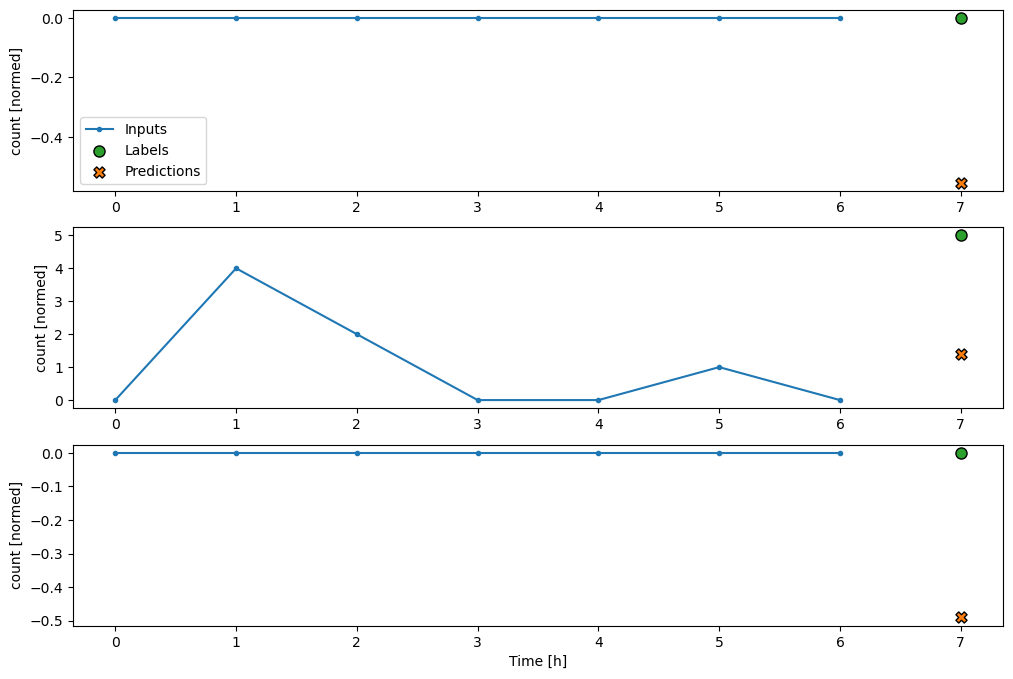

In [20]:
# Construir un modelo llamado 'lineal' con una única capa densa de una sola unidad. Usar los siguientes 
# elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
lineal = tf.keras.Sequential([
    tf.keras.layers.Dense(1)  # Capa densa con una sola unidad
])

# Compilar y evaluar el modelo 'lineal' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lineal, wg_7_1)

resultado_train = lineal.evaluate(wg_7_1.train)[-1]
resultado_val = lineal.evaluate(wg_7_1.val)[-1]
resultado_test = lineal.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['Lineal'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lineal)

In [21]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.6513


In [22]:

history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

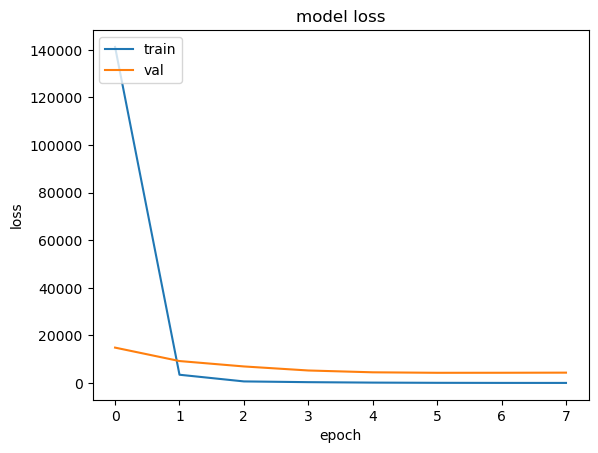

In [23]:
# curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

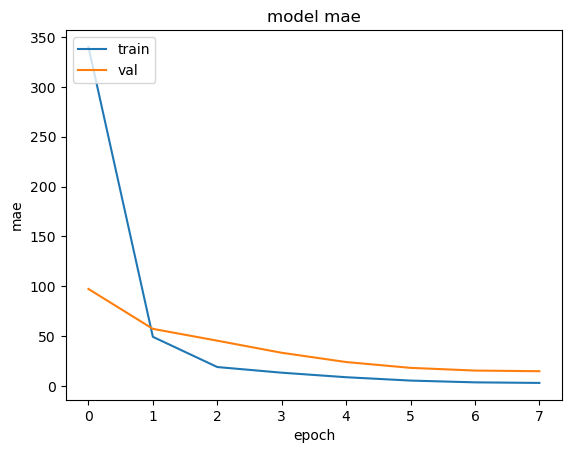

In [24]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/50
377/377 [==============================] - 2s 3ms/step - loss: 34.5178 - mean_absolute_error: 2.1489 - val_loss: 4697.4121 - val_mean_absolute_error: 14.1130
Epoch 2/50
377/377 [==============================] - 1s 2ms/step - loss: 33.3984 - mean_absolute_error: 2.2108 - val_loss: 4689.3354 - val_mean_absolute_error: 14.0464
Epoch 3/50
377/377 [==============================] - 1s 2ms/step - loss: 32.5595 - mean_absolute_error: 2.2663 - val_loss: 4682.2217 - val_mean_absolute_error: 13.9865
Epoch 4/50
377/377 [==============================] - 1s 2ms/step - loss: 31.9434 - mean_absolute_error: 2.3248 - val_loss: 4676.0791 - val_mean_absolute_error: 13.9711
Epoch 5/50
377/377 [==============================] - 1s 2ms/step - loss: 31.5082 - mean_absolute_error: 2.4176 - val_loss: 4670.8589 - val_mean_absolute_error: 13.9871
Epoch 6/50
377/377 [==============================] - 1s 2ms/step - loss: 31.2077 - mean_absolute_error: 2.5032 - val_loss: 4666.4277 - val_mean_absolute_e

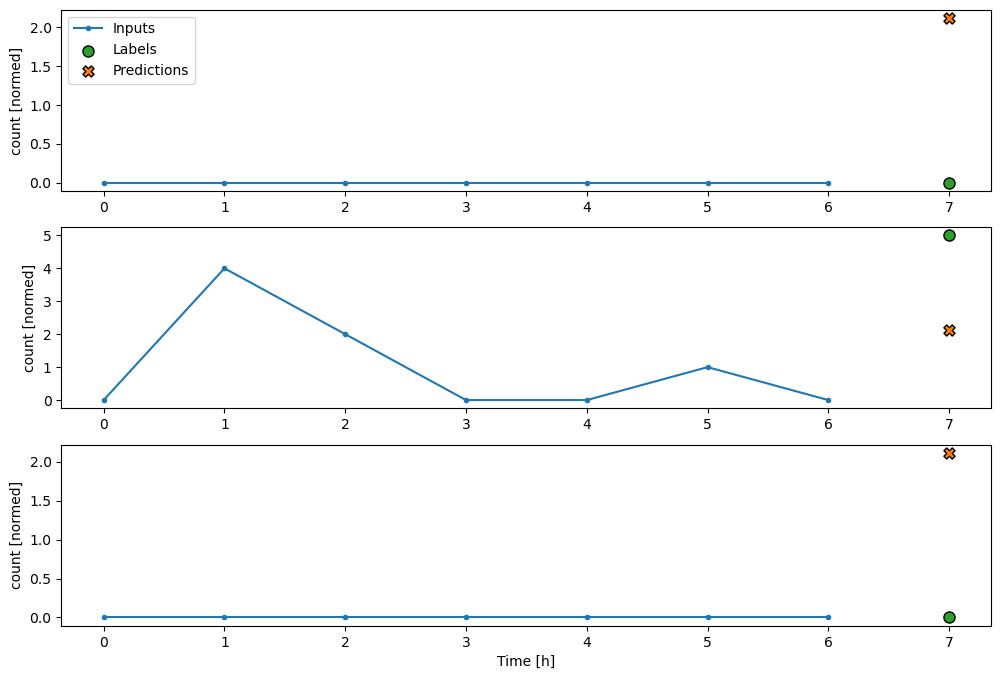

In [25]:
# construir un modelo llamado 'denso' con:
#   - Dos capas densas de 4 unidades, con función de activación ReLU
#   - Una capa densa final de una sola unidad, con función de activación lineal
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense

denso = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# compilar y evaluar el modelo 'denso' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Denso', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(denso, wg_7_1)

resultado_train = denso.evaluate(wg_7_1.train)[-1]
resultado_val = denso.evaluate(wg_7_1.val)[-1]
resultado_test = denso.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['Denso'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=denso)

In [26]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.651300
Denso,2.838336,14.069904,6.042957


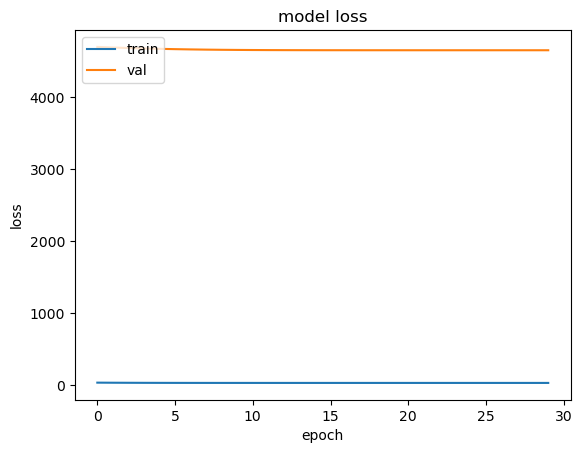

In [27]:
# Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/300
377/377 [==============================] - 7s 8ms/step - loss: 32.0890 - mean_absolute_error: 2.4331 - val_loss: 4300.1821 - val_mean_absolute_error: 13.1343
Epoch 2/300
377/377 [==============================] - 2s 6ms/step - loss: 30.6419 - mean_absolute_error: 2.7002 - val_loss: 4304.7759 - val_mean_absolute_error: 13.1001
Epoch 3/300
54/54 [==============================] - 0s 2ms/step - loss: 532.3728 - mean_absolute_error: 6.0971


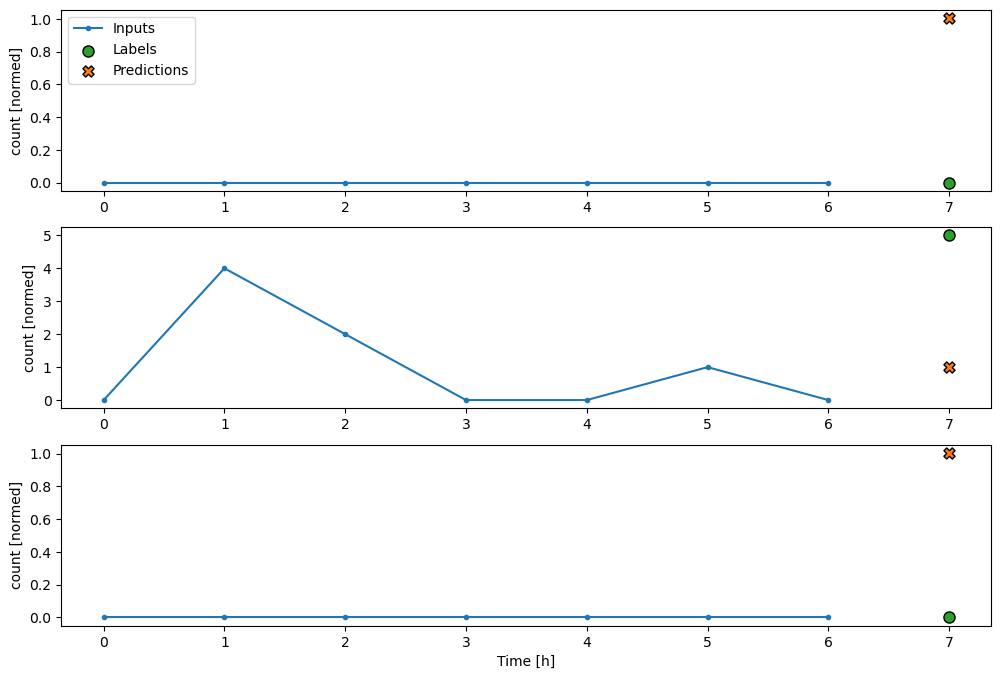

In [28]:
# Construir y evaluar un modelo llamado 'lstm' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(1)
])

# EJERCICIO: compilar y evaluar el modelo 'lstm' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'LSTM', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lstm, wg_7_1, max_epochs=300)

resultado_train = lstm.evaluate(wg_7_1.train)[-1]
resultado_val = lstm.evaluate(wg_7_1.val)[-1]
resultado_test = lstm.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['LSTM'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lstm)

In [29]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.651300
Denso,2.838336,14.069904,6.042957
LSTM,2.498533,13.073338,6.097133


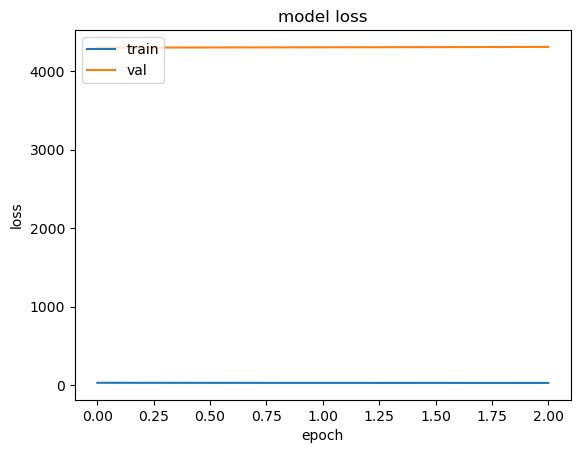

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/300
377/377 [==============================] - 6s 8ms/step - loss: 32.3225 - mean_absolute_error: 2.4064 - val_loss: 4296.3037 - val_mean_absolute_error: 13.1138
Epoch 2/300
377/377 [==============================] - 3s 7ms/step - loss: 31.2848 - mean_absolute_error: 2.7140 - val_loss: 4291.5566 - val_mean_absolute_error: 13.1323
Epoch 3/300
377/377 [==============================] - 2s 6ms/step - loss: 31.1164 - mean_absolute_error: 2.7567 - val_loss: 4290.1592 - val_mean_absolute_error: 13.1344
Epoch 4/300
377/377 [==============================] - 2s 6ms/step - loss: 31.0902 - mean_absolute_error: 2.7693 - val_loss: 4289.8662 - val_mean_absolute_error: 13.1323
Epoch 5/300
377/377 [==============================] - 3s 7ms/step - loss: 30.9914 - mean_absolute_error: 2.7757 - val_loss: 4289.1963 - val_mean_absolute_error: 13.1349
Epoch 6/300
377/377 [==============================] - 2s 6ms/step - loss: 30.9694 - mean_absolute_error: 2.7818 - val_loss: 4288.7510 - val_mean_abso

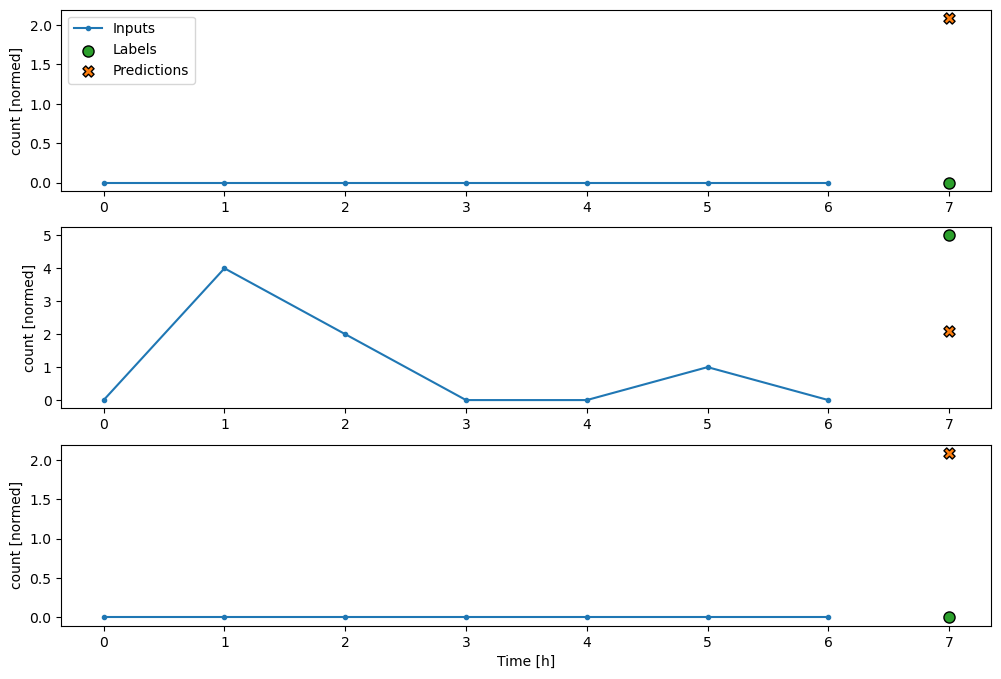

In [31]:
# construir y evaluar un modelo llamado 'lstm_dropout' con:
#   - Dos capas LSTM con 4 unidades
#   - Una capa dropout con una reducción del 20%
#   - Una capa densa de una sola unidad
# Usar los siguientes elementos de TensorFlow:
#   - tf.keras.Sequential
#   - tf.keras.layers.Dense
#   - tf.keras.layers.LSTM

lstm_dropout = tf.keras.Sequential([
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# EJERCICIO: compilar y evaluar el modelo 'lstm_dropout' con el generador 'wg_7_1'.
# Guardar el resultado de la función 'compile_and_fit' en un objeto history
# Guardar los resultados en el DataFrame RESULTADOS con la clave 'Lineal', usando el método evaluate
# Mostrar ejemplos de predicción con el método 'plot' del generador de ventanas.

history = compile_and_fit(lstm_dropout, wg_7_1, max_epochs=300)

resultado_train = lstm_dropout.evaluate(wg_7_1.train)[-1]
resultado_val = lstm_dropout.evaluate(wg_7_1.val)[-1]
resultado_test = lstm_dropout.evaluate(wg_7_1.test)[-1]

RESULTADOS.loc['LSTM-dropout'] = (resultado_train, resultado_val, resultado_test)
wg_7_1.plot('count', model=lstm_dropout)

In [32]:
RESULTADOS

,train,validation,test
Lineal,2.823605,14.675935,8.651300
Denso,2.838336,14.069904,6.042957
LSTM,2.498533,13.073338,6.097133
LSTM-dropout,2.809526,13.141443,6.012852


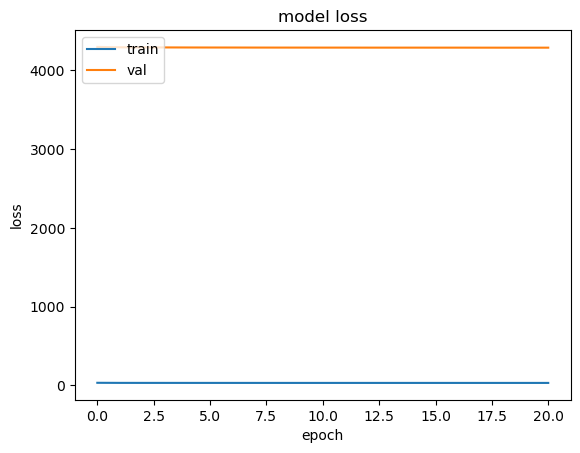

In [33]:
# Ejercicio: Dibuja las curvas de aprendizaje del modelo a través de las distintas epochs,
# haciendo uso de la información contenida en el objeto history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()